In [1]:
import os, sys
import pickle 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
sys.path.insert(0,'../../LongTermEMG-master')

# 0. Prepare Data
* 20 participants total (exclude 10 and 11)
* data from 3DC armband (10 channels with 1000 Hz)
* 150 ms frames with overlap of 100 ms; band-pass filter between 20-495 Hz using fourth-order butterworth filter
* dataset dict
    * examples_training
    * labels_training
    * training_datetimes
    * highest_activations
    * examples_evaluation
    * labels_evaluation
    * evaluation_emg_timestamps
    * angles_and_timestamps
    * evaluation_datetimes
* feature_set_function = feature_extraction.getTSD applied to each window 
    * exclude 0 sEMG recordings 
    * [1] A. Al-Timemy, R. N. Khushaba, G. Bugmann, and J. Escudero, "Improving the Performance Against Force Variation of EMG Controlled Multifunctional Upper-Limb Prostheses for Transradial Amputees", IEEE Transactions on Neural Systems and Rehabilitation Engineering, DOI: 10.1109/TNSRE.2015.2445634, 2015.
    * [2] R. N. Khushaba, Maen Takruri, Jaime Valls Miro, and Sarath Kodagoda, "Towards limb position invariant myoelectric pattern recognition using time-dependent spectral features", Neural Networks, vol. 55, pp. 42-58, 2014.

In [2]:
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.prepare_dataset_utils import butter_bandpass_filter, \
    show_filtered_signal, load_timestamps_from_participant, get_angles_from_positions_3d_arm
from LongTermClassificationMain.PrepareAndLoadDataLongTerm import feature_extraction

In [3]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/PrepareAndLoadDataLongTerm")
print(os.listdir("../../"))
from handcrafted_features_prepare_from_from_raw_dataset import read_data_training

['longterm_dataset_3DC.zip', 'longterm_dataset_3DC', 'README.md', 'LongTermClassificationMain', 'datasets', 'TransferLearning', '.idea', 'Weights_TSD']


In [4]:
list_participant_training_1_to_skip = ["Participant0/Training1", "Participant0/Evaluation2", "Participant0/Evaluation3",
                                       "Participant2/Training1", "Participant2/Evaluation2", "Participant2/Evaluation3"]

In [5]:
# features_set_name = "TSD_features_set"
# feature_set_function = feature_extraction.getTSD
# read_data_training(path="../../datasets/longterm_dataset_3DC", features_set_name=features_set_name, \
#                 feature_set_function=feature_set_function)

# 1. Temporal-Spatial Descriptors Deep Network (TSD_DNN)
* input size = 128 x 3 x 1 = 384
* 3 fully connected layers with 200 neurons 
    * batch normalization
    * leaky ReLU (0.1)
    * dropout (0.5)
* mean cross entropy loss
* optimization = ADAM (lr = 0.002515, beta = (0.5, 0.999))
* lr_scheduler (1e-8)
* dataloader needs
    * examples_training
    * labels_training
   
   
### Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures
    * best_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict 
    * fine-tune from the previous training      

In [6]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_Spectrogram_fine_tuning
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [7]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_standard import test_TSD_DNN_on_training_sessions

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [8]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

algo_name = "11Gestures_standard_ConvNet_THREE_Cycles_TSD"
path_to_save_to = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"

filter_size = [200, 200, 200]      
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11                          
learning_rate = 0.002515

In [9]:
# train_Spectrogram_fine_tuning(examples_datasets_train, labels_datasets_train, filter_size=None,
#                               num_kernels=filter_size, number_of_cycle_for_first_training=4,
#                               number_of_cycles_rest_of_training=4, path_weight_to_save_to=path_to_save_to,
#                               gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
#                               batch_size=128, spectrogram_model=False,
#                               feature_vector_input_length=feature_vector_input_length,
#                               learning_rate=learning_rate)

In [10]:
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=filter_size, use_only_first_training=True,
                                  path_weights=path_to_save_to,
                                  feature_vector_input_length=feature_vector_input_length,
                                  algo_name=algo_name, gestures_to_remove=gestures_to_remove,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

TSD_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    TSD_acc[i] = acc
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
TSD_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.588987,0.676030,0.555767
Participant_1,0.994555,0.629490,0.738581,0.882122
Participant_2,0.996020,0.209150,0.587406,0.578799


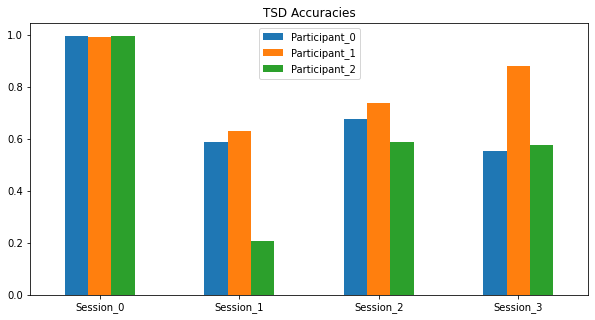

In [12]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_TSD.jpg")
plt.show()

# 2. Domain Adverserial Neural Network (DANN)
* 2 domians : source(0) and target(1) (output_domain includes 2 features)
    * source / validation: labeled; first training
    * target: unlabeled; others
    * train using one source and one target
* start training using TSD_DNN model params 
* DANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = crossEntropyLoss(pred_domain_source, label_source_domain)
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_domain_target = 0.5 * domain_loss_weight * loss_domain_target
    * loss_main = loss_main_source + loss_domain_target
    * loss_domain = loss_domain_source + loss_domain_target
   
### Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD
    * beat_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict     

In [13]:
from LongTermClassificationMain.TrainingsAndEvaluations.ForTrainingSessions.TSD_DNN.train_tsd_dnn_standard import \
    test_TSD_DNN_on_training_sessions
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_DA_spectrograms
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [14]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_DA import test_network_DA_algorithm

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [15]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [16]:
num_neurons = [200, 200, 200]
feature_vector_input_length = 385
gestures_to_remove = [5, 6, 9, 10]
gestures_to_remove = None
number_of_class = 11
number_of_cycle_for_first_training = 4
number_of_cycles_rest_of_training = 4
learning_rate = 0.002515

path_weights_fine_tuning = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "DANN_THREE_CYCLES_11Gestures_TSD"

In [17]:
# train_DA_spectrograms(examples_datasets_train, labels_datasets_train, filter_size=None,
#                       num_kernels=num_neurons, algo_name=algo_name,
#                       path_weights_fine_tuning=path_weights_fine_tuning,
#                       gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
#                       number_of_cycle_for_first_training=number_of_cycle_for_first_training,
#                       number_of_cycles_rest_of_training=number_of_cycles_rest_of_training,
#                       batch_size=128, spectrogram_model=False,
#                       feature_vector_input_length=feature_vector_input_length,
#                       path_weights_to_save_to="Weights_TSD/weights_", learning_rate=learning_rate)

In [18]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)   
test_network_DA_algorithm(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_neurons, path_weights_DA='Weights_TSD/weights_' + algo_name,
                              algo_name=algo_name,
                              path_weights_normal=path_weights_fine_tuning,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                              cycle_to_test=3)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [19]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

DANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    DANN_acc[i] = acc
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
DANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.610619,0.776217,0.639657
Participant_1,0.994555,0.674858,0.726919,0.876228
Participant_2,0.996020,0.192344,0.840226,0.830206


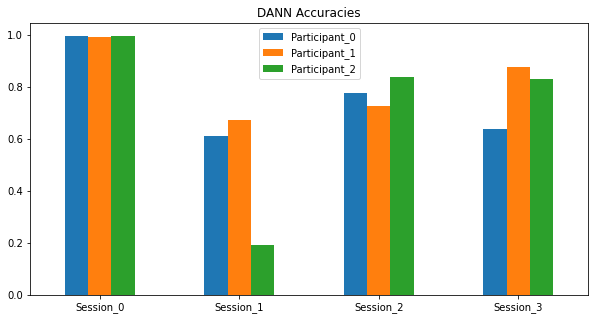

In [20]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_DANN.jpg")
plt.show()

# 3. SCADANN
* start training using TSD_DNN model params for the first training seesion, then using DANN model params 
* first traning = labeled, others = pseudo labels 
    * train using one lebaled and n psuedo labeled (n = #session)
* use all training data at once
* pseudo_labels_heuristic
    * window_stable_mode_length = 30 (hold stable for 1.5s)
    * percentage_same_gesture_now_stable = 65% (remove examples that are likely to generate false pseudo labels)
    * maximum_length_instability_gesture_transition = 40
    * maximum_length_instability_same_gesture = 40 (remove examples that are unstable for more than 2s)
* SCADANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = ((1 - alpha) * crossEntropyLoss(pred_domain_source, label_source_domain))
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_main_target = (0.5 * loss_target_class + domain_loss_weight * loss_domain_target)
    * loss_main = loss_main_source + loss_main_target
    * loss_domain = loss_domain_source + loss_domain_target

   

### Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN
* beat_state_n.pt (n = # training session)
    * epoch: #epochs
    * model state_dict
    * optimizer state_dict
    * scheduler state_dict     

In [21]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import load_checkpoint
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.load_dataset_spectrogram_in_dataloader import \
    load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.self_learning.self_learning_utils import \
    generate_dataloaders_for_SCADANN
from LongTermClassificationMain.Models.model_training_self_learning import SCADANN_BN_training


In [22]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from SCADANN_TSD_DNN_training_session import run_SCADANN_training_sessions, test_network_SLADANN
batch_size = 256

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [23]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)
examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [24]:
num_neurons = [200, 200, 200]
learning_rate = 0.002515
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11
percentage_same_gesture_stable = 0.65  # 0.65 for 11 gestures, 0.85 for 7 gestures
path_weight_to_save_to = "Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN"
path_weights_start_with = "Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD"
path_weights_Normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "SCADANN_THREE_CYCLES_11Gestures_TSD"

In [25]:
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_weight_to_save_to,
#                               path_weights_Adversarial_training=path_weights_start_with,
#                               path_weights_Normal_training=path_weights_Normal_training,
#                               number_of_cycle_for_first_training=4, number_of_cycles_rest_of_training=4,
#                               gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [26]:
path_weights_normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                     path_weights_ASR=path_weight_to_save_to, path_weights_normal=path_weights_normal_training,
                     algo_name=algo_name, cycle_test=3, gestures_to_remove=gestures_to_remove,
                     number_of_classes=number_of_classes)

(4,)   0
SHAPE X:  (1854, 385)
(4,)   1
SHAPE X:  (1899, 385)
(4,)   2
SHAPE X:  (1938, 385)
(4,)   3
SHAPE X:  (1780, 385)
(4,)   0
SHAPE X:  (1981, 385)
(4,)   1
SHAPE X:  (1884, 385)
(4,)   2
SHAPE X:  (1884, 385)
(4,)   3
SHAPE X:  (1809, 385)
(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1928, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1902, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inpla

In [27]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

SCADANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    SCADANN_acc[i] = acc
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
SCADANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,0.997041,0.575221,0.793071,0.626311
Participant_1,0.994555,0.689981,0.724004,0.888016
Participant_2,0.996020,0.152194,0.947368,0.958724


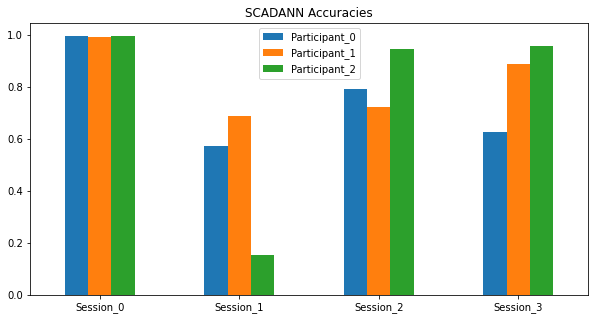

In [28]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/3DC_SCADANN.jpg")
plt.show()

# Conclusion

In [29]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.702829
DANN,0.762908
SCADANN,0.778542


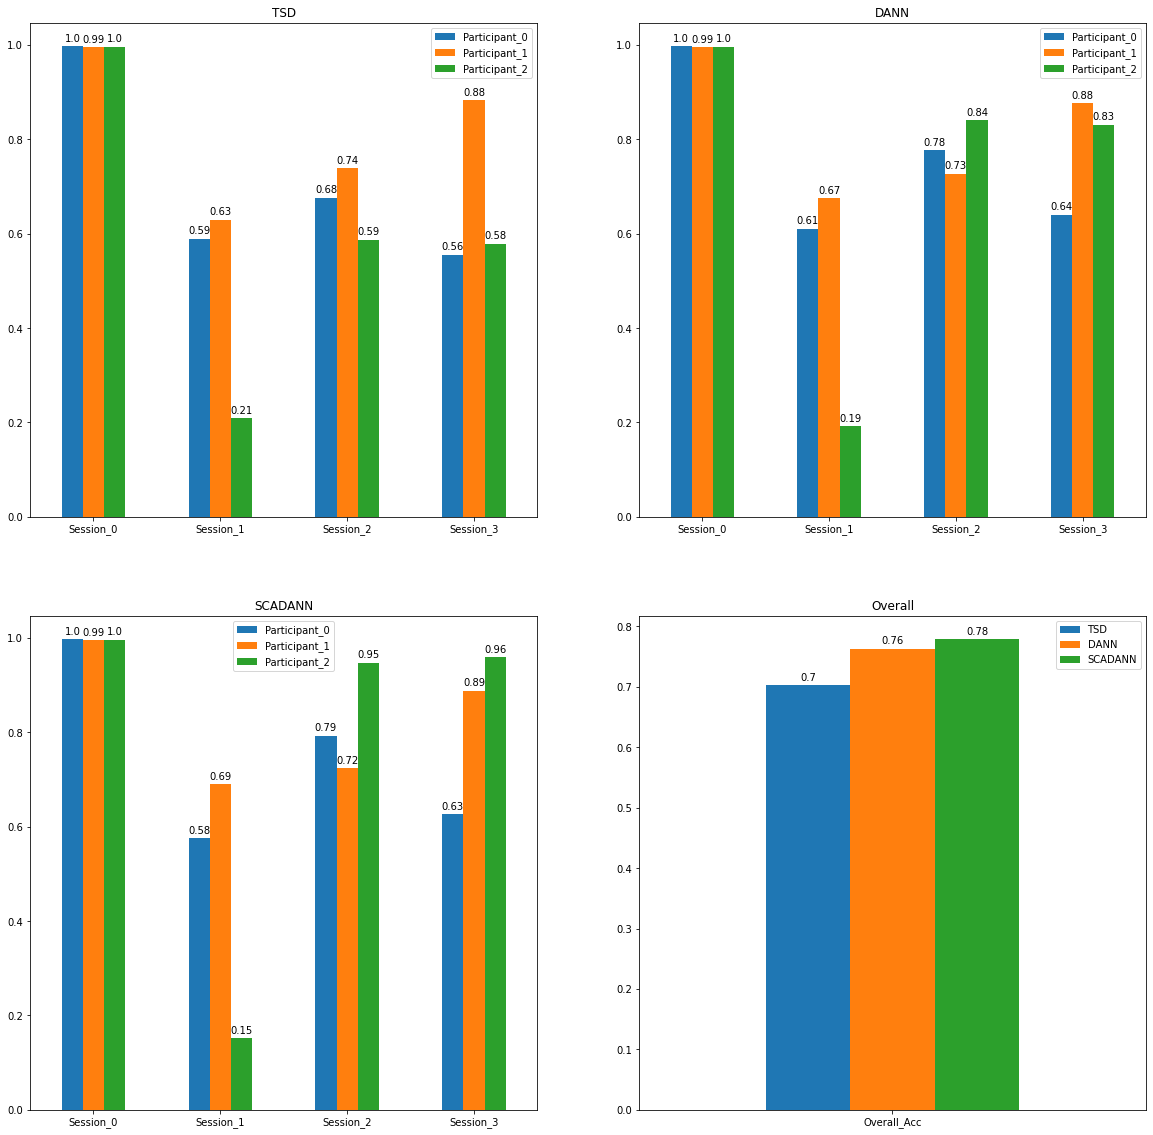

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')


Note for 2_only dataset:   
* result from STD -> DANN -> SCADANN  
    * 10.0 -> 17.9 -> 16.0
    * 17.2 -> 17.9 -> 16.9
    * 14.3 -> 16.5 -> 14.6
    * 12.7 -> 19.0 -> 16.4
* maybe this is just a bad data  
* percentage_same_gesture_stable=0.65
    * maybe too many unstable examples 